In [1]:
from pandas_datareader import data as datareader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime

/anaconda2/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data reading

In [3]:
data = pd.read_csv('aapl_dataset.csv', index_col = 'Date')

In [4]:
data = data.dropna()

In [5]:
data.tail()

,high,low,open,close,volume,adj close,feat_RSI_close,feat_OBV_volume,feat_ATR_close,feat_HT_DCPERIOD_close,feat_HT_DCPHASE_close,feat_FUNDAMENTAL1_CHG,feat_FUNDAMENTAL2_CHG,feat_K10_FILING,feat_SENTIMENT_UP,feat_DIVIDEND
Date,,,,,,,,,,,,,,,,
2019-12-24,284.890015,282.920013,284.690002,284.269989,12119700.0,283.596924,74.436585,2.224292e+10,3.913542,28.454955,150.076370,-0.337975,0.541358,3,0,-0.982111
2019-12-26,289.980011,284.700012,284.820007,289.910004,23280300.0,289.223602,78.678994,2.226620e+10,4.041862,28.079039,153.345130,-0.408145,0.929980,0,1,-2.587859
2019-12-27,293.970001,288.119995,291.119995,289.799988,36566500.0,289.113831,78.405656,2.222964e+10,4.171015,27.740405,156.893808,0.162783,0.732749,3,1,0.814541
2019-12-30,292.690002,285.220001,289.459991,291.519989,36028600.0,290.829773,79.598963,2.226566e+10,4.406657,27.553361,160.727817,-0.933116,0.980977,0,0,-1.696447
2019-12-31,293.679993,289.519989,289.929993,293.649994,25201400.0,292.954712,80.999258,2.229087e+10,4.389039,27.941882,164.208211,0.383039,0.336035,1,0,0.176790


# Data Preparation

In [6]:
from mlfinlab.features.fracdiff import frac_diff_ffd
from utils import get_meta_barier, getDailyVol

In [7]:
frac_diff_series = frac_diff_ffd(pd.DataFrame(np.log(data['close'])), 0.7, thresh=1e-4)

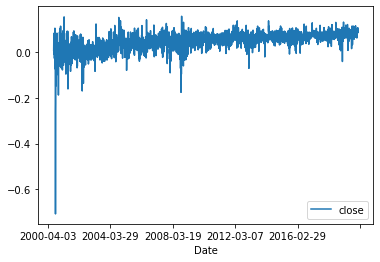

In [8]:
frac_diff_series.plot()

# Feature Extraction

In [9]:
from mlfinlab.microstructural_features import get_roll_measure, get_roll_impact

In [10]:
WINDOW = 30

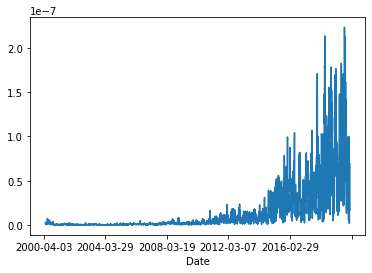

In [13]:
# get_roll_measure(data['close'], WINDOW).plot()
get_roll_impact(data['close'], data['volume'], WINDOW).plot()

In [14]:
from mlfinlab.microstructural_features import get_corwin_schultz_estimator, get_bekker_parkinson_vol

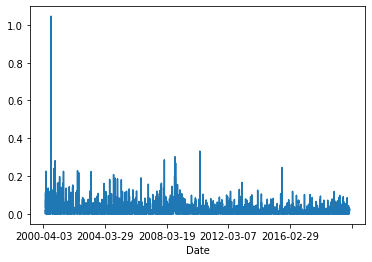

In [17]:
# get_corwin_schultz_estimator(data['high'], data['low'], WINDOW).plot()
get_bekker_parkinson_vol(data['high'], data['low'], WINDOW).plot()

In [18]:
from mlfinlab.microstructural_features import get_bar_based_kyle_lambda, get_bar_based_amihud_lambda, get_bar_based_hasbrouck_lambda

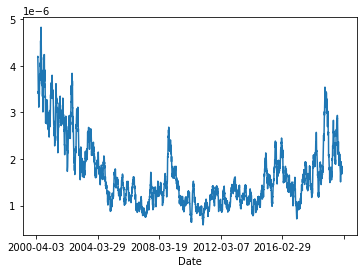

In [19]:
# get_bar_based_kyle_lambda(data['close'], data['volume'], WINDOW).plot()
# get_bar_based_amihud_lambda(data['close'], data['volume'], WINDOW).plot()
get_bar_based_hasbrouck_lambda(data['close'], data['volume'], WINDOW).plot()

# Feature Definition

In [20]:
data['feat_new_roll_measure'] = get_roll_measure(data['close'], WINDOW)
data['feat_new_roll_impact'] = get_roll_impact(data['close'], data['volume'], WINDOW)
data['feat_new_corwin_schultz'] = get_corwin_schultz_estimator(data['high'], data['low'], WINDOW)
data['feat_new_bekker_parkinson_vol'] = get_bekker_parkinson_vol(data['high'], data['low'], WINDOW)
data['feat_new_kyle_lambda'] = get_bar_based_kyle_lambda(data['close'], data['volume'], WINDOW)
data['feat_new_amihud_lambda'] = get_bar_based_amihud_lambda(data['close'], data['volume'], WINDOW)
data['feat_new_hasbrouck_lambda'] = get_bar_based_hasbrouck_lambda(data['close'], data['volume'], WINDOW)

In [21]:
data['feat_new_min_frac_close'] = frac_diff_series.rolling(WINDOW).min()
data['feat_new_max_frac_close'] = frac_diff_series.rolling(WINDOW).max()
data['feat_new_mean_frac_close'] = frac_diff_series.rolling(WINDOW).mean()
data['feat_new_std_frac_close'] = frac_diff_series.rolling(WINDOW).std()
data['feat_new_skew_frac_close'] = frac_diff_series.rolling(WINDOW).skew()
data['feat_new_kurt_frac_close'] = frac_diff_series.rolling(WINDOW).kurt()
data['feat_new_autocorr_frac_close'] = frac_diff_series.rolling(WINDOW).apply(lambda x: x.autocorr(), raw=False)

In [22]:
FEATURE_COLUMNS = [d for d in data.columns if 'feat_new' in d]

In [23]:
dataset = data[FEATURE_COLUMNS]

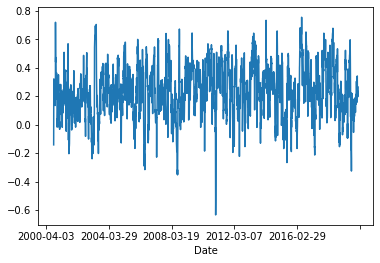

In [30]:
data['feat_new_autocorr_frac_close'].plot()

In [31]:
dataset['close'] = data['close']
dataset = dataset.dropna()

In [33]:
HORIZON = 1

def createXY(inputs, outputs):   
    X, Y, P = [], [], []
    for i in range(WINDOW, len(inputs)-HORIZON, 1):

        window = inputs[i-WINDOW:i].values
        future = (outputs[i+HORIZON] - outputs[i]) / outputs[i]

        X.append(window)
        Y.append(np.sign(future))
        P.append(future)

    X, Y, P = np.array(X), np.array(Y), np.array(P)
    return X, Y, P

In [34]:
X_train, Y_train, P_train = createXY(dataset[FEATURE_COLUMNS], dataset['close'])
X_test, Y_test, P_test = createXY(dataset[FEATURE_COLUMNS], dataset['close'])

# Modeling

In [35]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import r2_score, matthews_corrcoef, f1_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [36]:
mmcs, pred_prs = [], []
for n in range(50):
    clf = BaggingClassifier(RidgeClassifier())
    clf.fit(X_train.mean(axis=1), Y_train)
    pred = clf.predict(X_test.mean(axis=1))
    pred_pr = clf.predict_proba(X_test.mean(axis=1))
    mmcs.append(matthews_corrcoef(Y_test, pred))
    pred_prs.append(pred_pr)

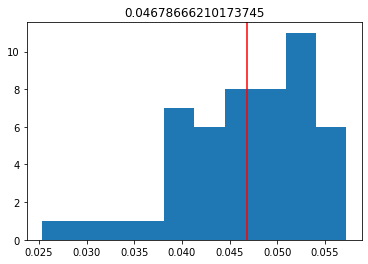

In [37]:
plt.figure()
plt.title(str(np.mean(mmcs)))
plt.hist(mmcs)
plt.axvline(np.mean(mmcs), color = 'red')
plt.show()

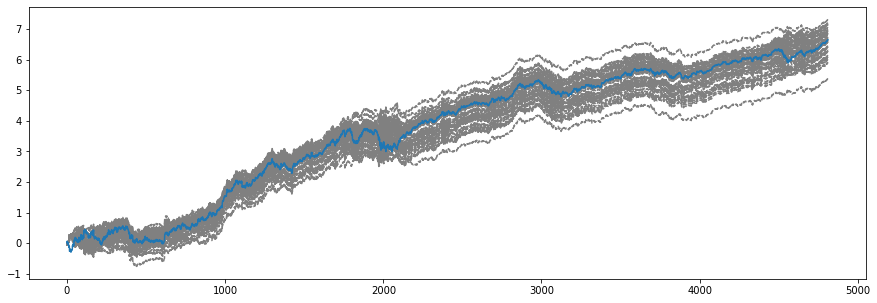

In [38]:
plt.figure(figsize = (15, 5))

for pred_pr in pred_prs:
    signal = [-p[0] if p[2] <= 0.5 else p[2] for p in pred_pr] # TODO FIX STRATEGY!!!!
    plt.plot((signal * P_test).cumsum(), color = 'grey', ls = '--')
plt.plot(P_test.cumsum())
plt.show()

In [39]:
benchmark_returns = P_test
strategy_returns = signal * P_test

# Evaluation

In [40]:
from mlfinlab.backtest_statistics import sharpe_ratio
from mlfinlab.backtest_statistics import probabilistic_sharpe_ratio
from mlfinlab.backtest_statistics import deflated_sharpe_ratio
from mlfinlab.backtest_statistics import information_ratio
from mlfinlab.backtest_statistics import minimum_track_record_length
from mlfinlab.backtest_statistics import drawdown_and_time_under_water

In [41]:
benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
benchmark_sharpe

0.9546512230153585

In [42]:
strategy_sharpe = sharpe_ratio(strategy_returns, entries_per_year=252)
strategy_sharpe

0.9984743553822628

In [43]:
psr = probabilistic_sharpe_ratio(strategy_sharpe, benchmark_sharpe, len(benchmark_returns))
psr

0.9934879892849713

In [44]:
all_strategy_sharpes = []
for r in pred_prs:
    signal = [-p[0] if p[2] <= 0.5 else p[2] for p in np.mean(pred_prs, axis=0)]
    sr_i = sharpe_ratio(signal * P_test, entries_per_year=252)
    all_strategy_sharpes.append(sr_i)

dsr = deflated_sharpe_ratio(strategy_sharpe, all_strategy_sharpes, len(benchmark_returns))
dsr

1.0

In [45]:
ir = information_ratio(strategy_returns, benchmark=np.mean(benchmark_returns), entries_per_year=252)
ir

-0.08141447748711197

In [46]:
mtrl = minimum_track_record_length(strategy_sharpe, benchmark_sharpe)
mtrl

2112.04422979583

# Checking Feature Importance

In [47]:
import shap
from sklearn.ensemble import RandomForestClassifier

In [48]:
X_train_df = pd.DataFrame(X_train.mean(axis=1), columns = FEATURE_COLUMNS)
X_test_df = pd.DataFrame(X_test.mean(axis=1), columns = FEATURE_COLUMNS)

In [49]:
clf = RandomForestClassifier(1)
clf.fit(X_train_df, Y_train)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_df)

fi0 = np.abs(shap_values[0]).mean(axis=0)
fi1 = np.abs(shap_values[1]).mean(axis=0)
fi = fi0 + fi1
imp = pd.DataFrame({
    'feature': X_train_df.columns.tolist(),
    'mean': fi
})
imp = imp.set_index('feature')

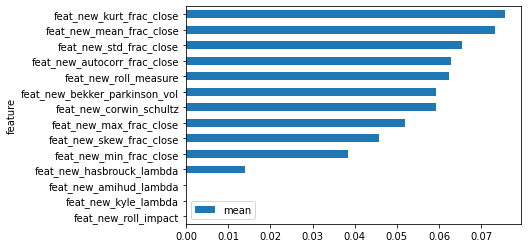

In [50]:
imp.sort_values('mean').plot.barh()

In [51]:
imp.sort_values('mean')[::-1][:10].index.values

array(['feat_new_kurt_frac_close', 'feat_new_mean_frac_close',
       'feat_new_std_frac_close', 'feat_new_autocorr_frac_close',
       'feat_new_roll_measure', 'feat_new_bekker_parkinson_vol',
       'feat_new_corwin_schultz', 'feat_new_max_frac_close',
       'feat_new_skew_frac_close', 'feat_new_min_frac_close'],
      dtype=object)

In [52]:
IMPORTANT_FEATURES = imp.sort_values('mean')[::-1][:10].index.values.tolist()

# Retraining on the best features

In [53]:
X_train, Y_train, P_train = createXY(dataset[IMPORTANT_FEATURES], dataset['close'])
X_test, Y_test, P_test = createXY(dataset[IMPORTANT_FEATURES], dataset['close'])

In [54]:
mmcs, pred_prs = [], []
for n in range(50):
    clf = BaggingClassifier(RidgeClassifier())
    clf.fit(X_train.mean(axis=1), Y_train)
    pred = clf.predict(X_test.mean(axis=1))
    pred_pr = clf.predict_proba(X_test.mean(axis=1))
    mmcs.append(matthews_corrcoef(Y_test, pred))
    pred_prs.append(pred_pr)

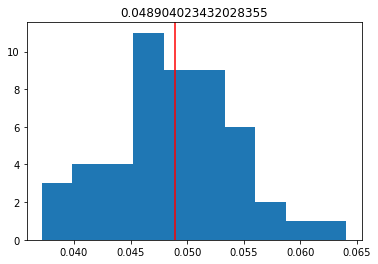

In [55]:
plt.figure()
plt.title(str(np.mean(mmcs)))
plt.hist(mmcs)
plt.axvline(np.mean(mmcs), color = 'red')
plt.show()

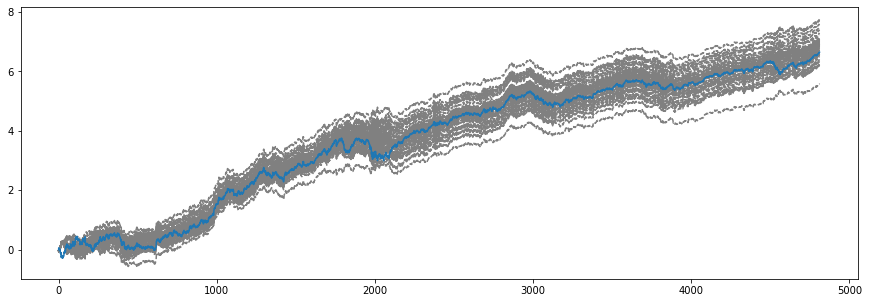

In [63]:
plt.figure(figsize = (15, 5))

for pred_pr in pred_prs:
    signal = [-p[0] if p[2] <= 0.5 else p[2] for p in pred_pr]
    plt.plot((signal * P_test).cumsum(), color = 'grey', ls = '--')
plt.plot(P_test.cumsum())
plt.show()

In [57]:
strategy_returns_features = signal * P_test

In [58]:
benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
benchmark_sharpe

0.9546512230153585

In [59]:
strategy_sharpe = sharpe_ratio(strategy_returns, entries_per_year=252)
strategy_sharpe

0.9984743553822628

In [60]:
strategy_sharpe_features = sharpe_ratio(strategy_returns_features, entries_per_year=252)
strategy_sharpe_features

1.2799332931991731

In [61]:
psr = probabilistic_sharpe_ratio(strategy_sharpe_features, strategy_sharpe, len(benchmark_returns))
psr

1.0

# Cross-Validation

# Backtesting